# Model Evaluation

## Validating models
One of the most important pieces of machine learning is *model evaluation*: that is, checking how well your model fits a given dataset. But of course this is not without issues that need to be addressed.

In order to look into this matter, let's consider a new sample dataset from sklearn: [digit dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#). 

### Dataset summary
*   Classes: 10
*   Samples per class: ~180
*   Samples total: 1797
*   Dimensionality: 64


In [1]:
from sklearn.datasets import load_digits

digits = load_digits() # load dataset
print(digits.data.shape) # samples vs dimensions

(1797, 64)


Plot one example of the digit: 

<Figure size 640x480 with 0 Axes>

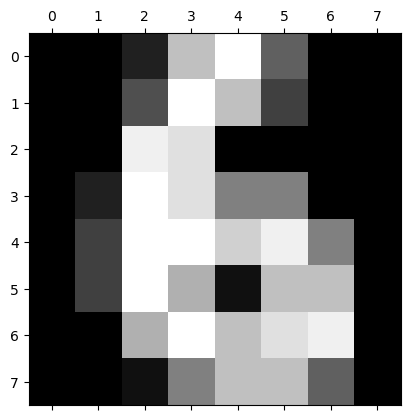

In [2]:
from matplotlib import pyplot as plt

plt.gray()
plt.matshow(digits.images[453]) # pick any random number plot them

or plot some of the 0 - 9 digits in a 8x8 grid:

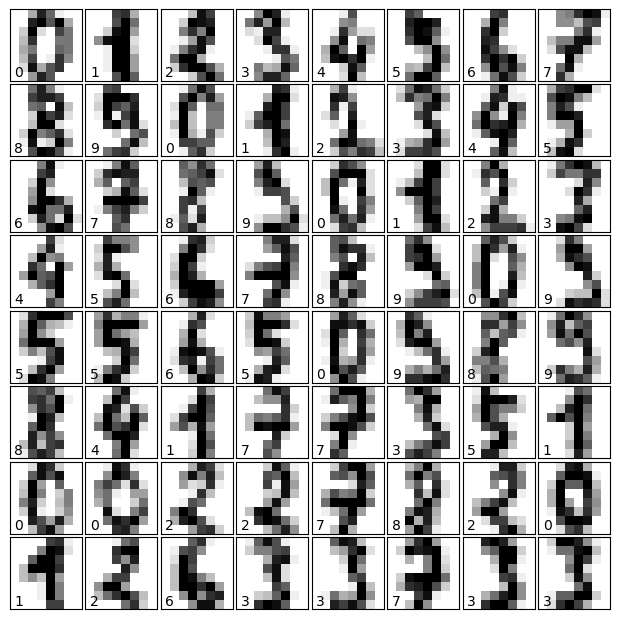

In [4]:
fig = plt.figure(figsize=(6, 6))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):

    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Let's fit a k-NN classifier and try to check how well our model fits the data.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

X = digits.data
y = digits.target

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=1)

Now let's try using this classifier to predict *targets* (labels) for the data and check how well our prediction did:

In [9]:
y_pred = knn.predict(X)
print("{0} / {1} correct".format(np.sum(y==y_pred), len(y)))

1797 / 1797 correct


Seems like we have a perfect classifier....yes?

#### Question: what's wrong with this?

We actually made the mistake of testing our data on the same set of data was used for training - definitely not a good idea. If we use this way, we will tend to *overfit* the data: that is, we learn the noise.

## Validation sets
A better way to test a model is to use a hold-out set which doesn't enter the training. This can be achieved using sklearn's train/test utility:

In [10]:
from sklearn.model_selection import train_test_split

Utility documentation:

In [11]:
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True)
print(f"Training set: {X_train.shape}, test set: {X_test.shape}")

Training set: (1347, 64), test set: (450, 64)


Now we train on the training data:

In [31]:
correct_knn = KNeighborsClassifier(n_neighbors=1)
correct_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

 and validate on the test data:

In [32]:
y_pred = correct_knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test==y_pred), len(y_test)))

445 / 450 correct


This gives us a more reliable estimate of how our model is doing. You may get different results but one thing for sure, it is not going to be 450/450 correct!

## Accuracy score
The metric we are using here, comparing the number of matches to the total number of samples, is known as the *accuracy score*, and can be computed using the following routine:

In [33]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9888888888888889

or alternatively computed directly from the `model.score` method:

In [34]:
correct_knn.score(X_test, y_test)

0.9888888888888889

Using this, we can now see how the accuracy score changes as we change the model parameters, in this case the value of $k$ (number of neighbours).

In [35]:
accu = []
kn = range(1,1000,9)

for k in kn:
  new_knn = KNeighborsClassifier(n_neighbors=k)
  new_knn.fit(X_train, y_train)
  acc = new_knn.score(X_test, y_test)
  # print(f"Neighbours (k) = {k}, Accuracy = {acc}")
  accu.append(acc)

and let's plot the accuracy score results against $k$:

/var/folders/ql/p3kfkc9j0yg9y6hmz6mjxnr00000gn/T/ipykernel_56984/4223339981.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


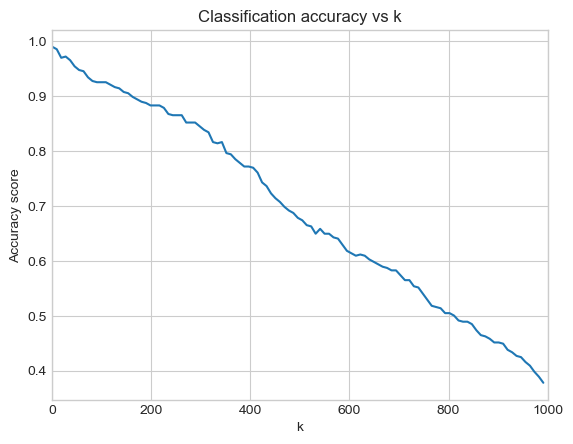

In [36]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(kn, accu)
plt.xlim(0,1000)
plt.title("Classification accuracy vs k")
plt.xlabel("k")
plt.ylabel("Accuracy score");

## Cross-validation
One issue with validation sets is that you "lose" some of the data. Previously when we used sklearn's `train_test_split`, we were actually used $\frac{3}{4}$ of the data for training, and used $\frac{1}{4}$ for the validation. 

A better way of validating our model withour "losing" our data, is to use *2-fold cross-validation*, where we split the sample (data) in half and perform the validation twice:

In [44]:
Xtrain1, Xtrain2, ytrain1, ytrain2 = train_test_split(X, y, test_size=0.5, random_state=0)

Note that `test_set=0.5` means now we have split the data into half (50:50) between train and test. Also `random_state = 0` sets a seed to the random generator, so that our train-test splits are always deterministic. Otherwise, it will different each time. 

In [45]:
print(f"Xtrain1.shape: {Xtrain1.shape}, Xtrain2.shape: {Xtrain2.shape}") # check shape of the sample

Xtrain1.shape: (898, 64), Xtrain2.shape: (899, 64)


In [46]:
accu = []
cv_knn = KNeighborsClassifier(n_neighbors=1)

accu.append(cv_knn.fit(Xtrain1, ytrain1).score(Xtrain2, ytrain2))
accu.append(cv_knn.fit(Xtrain2, ytrain2).score(Xtrain1, ytrain1))

print(f"Fold-1: {accu[0]}")
print(f"Fold-2: {accu[1]}")

Fold-1: 0.982202447163515
Fold-2: 0.9832962138084632


Thus a two-fold cross-validation gives us two estimates of the score for that parameter. We can then get the mean (average) of the scores:

In [47]:
np.array(accu).mean()

0.9827493304859891

The above technique is quite a pain to do manually. Fortunately sklearn has a utility routine to help:

In [51]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=2)
cv.mean()

0.9610455566813907

## $K$-fold cross-validation
Previously we've used 2-fold cross-validation which basically is one type of $K$-fold cross-validation (where $K = 2,3,...,n$) where we split the data into $K$ chunks and perform $K$ validation, where each chunk gets a turn as the validation set. This can be done by changing the `cv` parameter in `cross_val_score` function. To do a 15-fold cross-validation:


In [53]:
cv = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=30)
print(f"Score: {cv}")
print(f"Score mean: {cv.mean()}")
print(f"Score standard deviation: {cv.std()}")

Score: [0.96666667 0.96666667 0.98333333 1.         1.         1.
 1.         1.         0.98333333 0.98333333 1.         0.98333333
 1.         0.96666667 0.98333333 1.         1.         0.96666667
 0.98333333 1.         1.         1.         0.98333333 1.
 1.         0.98333333 0.98333333 0.96610169 1.         0.98305085]
Score mean: 0.9888606403013183
Score standard deviation: 0.01246094334185703


And let's plot the cross-validation scores:

Text(0, 0.5, 'Accuracy score')

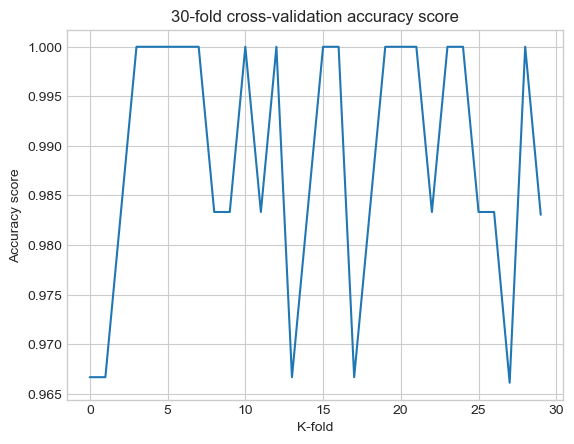

In [56]:
plt.plot(cv)
plt.title("30-fold cross-validation accuracy score")
plt.xlabel("K-fold")
plt.ylabel("Accuracy score")

This gives us an even better idea of how well our model is doing. We also can see that the standard deviation of the scores is small, suggesting that our $k$-NN model is stable. 

# Evaluating unsupervised learning models (Clustering)

Clustering requires different evaluation. We look at two methods that are commonly used to evaluate the appropriate number of clusters:

1. The elbow method
2. The silhouette coefficient


In [2]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

We start with creating synthetic cluster data and labels:

In [3]:
features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

Visualise the data

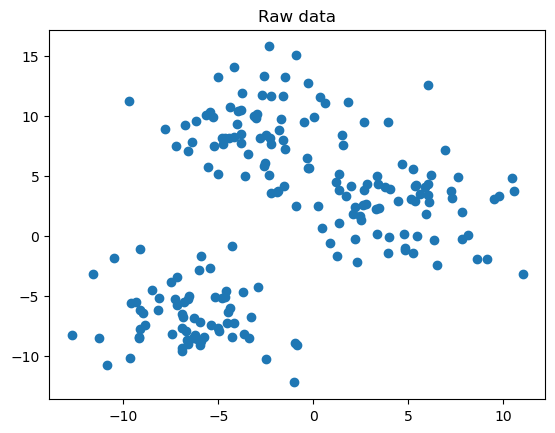

In [6]:
import matplotlib.pyplot as plt

plt.scatter(features[:,0], features[:,1]) # 0-th position = x coords; 1-th position = y coords
plt.title("Raw data")
plt.show()

We transform numerical features to use the same scale - important step for most distance-based machine learning algorithms because it can have a significant impact on the performance of your algorithm

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

The structure of the scaled data remain the same as the original.

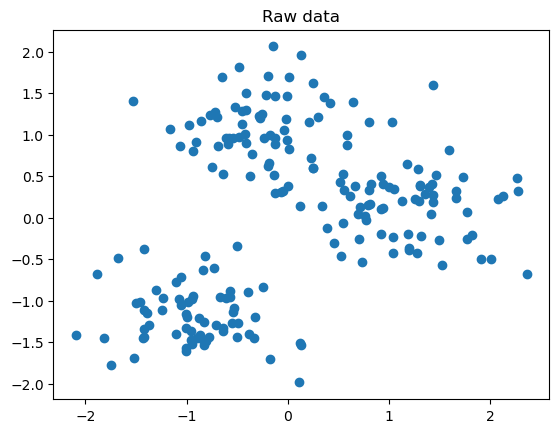

In [8]:
plt.scatter(scaled_features[:,0], scaled_features[:,1]) # 0-th position = x coords; 1-th position = y coords
plt.title("Raw data")
plt.show()

Instantiate the KMeans class and fit the data:

In [11]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=300, random_state=42)

In [12]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

Statistics from the initialization run with the lowest **Sum of Squares Errors** (or SSE), which is the sum of the distances of all points within a cluster from the centroid of the point are available as attributes of kmeans after calling ``.fit()``:

In [16]:
print("The lowest SSE value:", kmeans.inertia_)
print("Final locations of the centroid (x,y):\n", kmeans.cluster_centers_)
print("The number of iterations required to converge:", kmeans.n_iter_)

The lowest SSE value: 74.57960106819854
Final locations of the centroid (x,y):
 [[ 1.19539276  0.13158148]
 [-0.25813925  1.05589975]
 [-0.91941183 -1.18551732]]
The number of iterations required to converge: 10


## Choosing the appropriate number of clusters

### Elbow method
To perform the elbow method, run several *k*-means, increment *k* with each iteration, and record the SSE:

In [18]:
# parameters dictionary
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

SSE plot

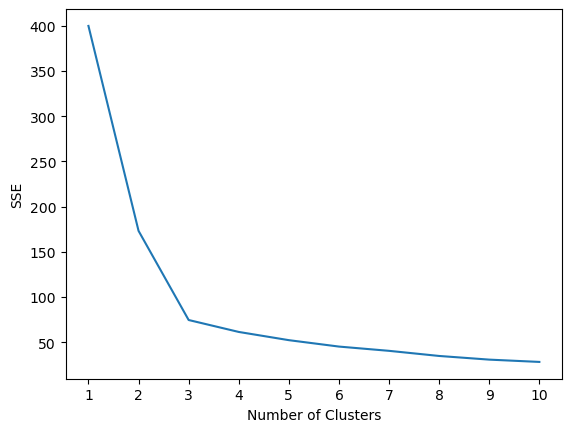

In [19]:
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In this example, the elbow is located at $x=3$. 

In some cases, determining the elbow point in the SSE curve isn’t always straightforward. In this case, we could use `kneed`, to identify the elbow point programmatically:

In [21]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

print("Elbow point x =", kl.elbow)

Elbow point x = 3


### Silhouette coefficient

It is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

1. How close the data point is to other points in the cluster
2. How far away the data point is from points in other clusters

Silhouette coefficient values range between $-1$ and $1$. Larger numbers indicate that samples are closer to their clusters than they are to other clusters. In Python `scikit-learn`'s `silhouette_score()` function needs a minimum of two clusters, or it will raise an exception.

In [22]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

Plotting the average silhouette scores for each *k* shows that the best choice for *k* is 3 since it has the maximum score:

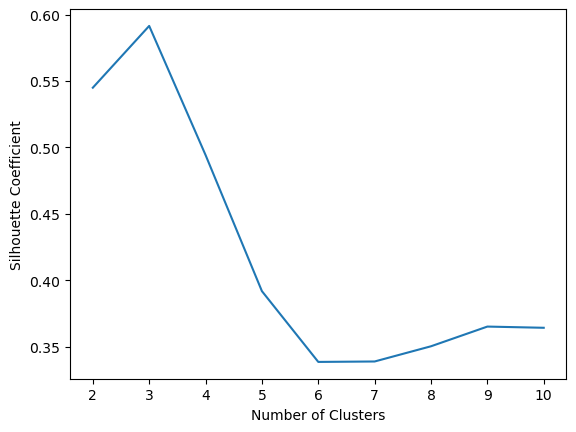

In [23]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Comparative analysis to determine best value of *k* using Silhouette plot

We use [YellowBrick](https://www.scikit-yb.org/en/latest/index.html) – a machine learning visualisation library to draw the silhouette plots and perform comparative analysis.

In [ ]:
#  install Yellowbrick

%pip install yellowbrick

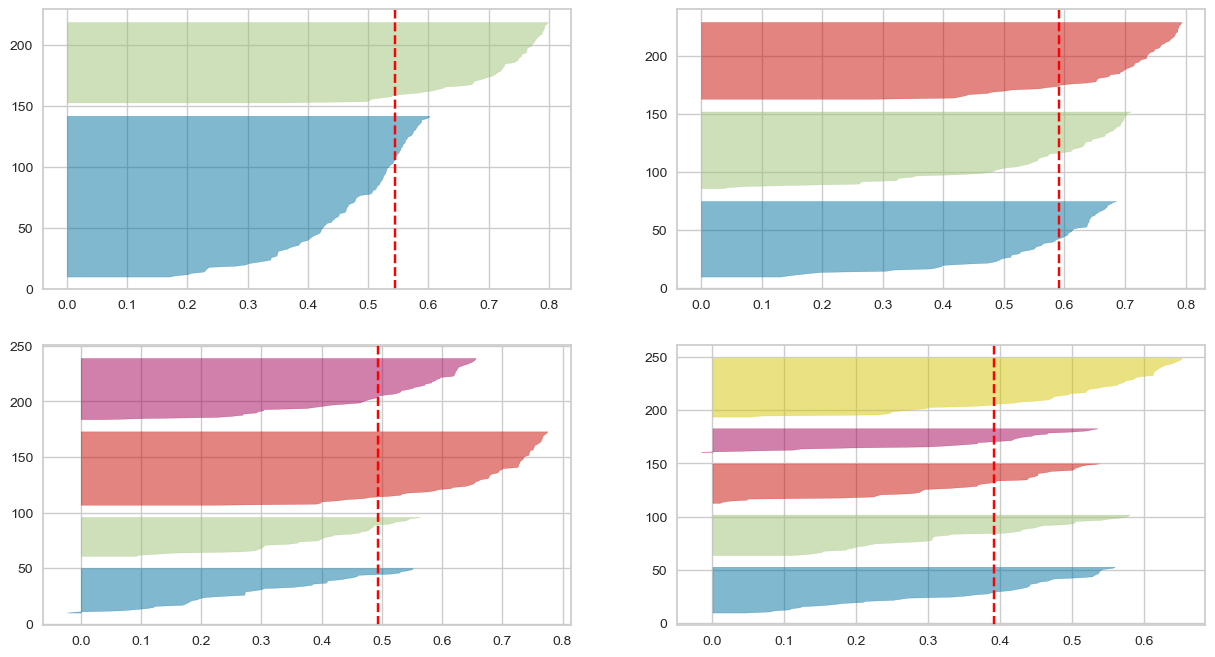

In [26]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    # Create KMeans instance for different number of clusters
    # km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=100, random_state=42)
    km - KMeans(n_clusters=i, **kmeans_kwargs)
    q, mod = divmod(i, 2)

    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
    vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis.fit(scaled_features) 

Here is the Silhouette analysis done on the above plots with an aim to select an optimal value for `n_clusters`:

The value of n_clusters as $4$ and $5$ looks to be suboptimal for the given data due to the following reasons:

1. Presence of clusters with below average silhouette scores
2. Wide fluctuations in the size of the silhouette plots.

The value of $2$ and $3$ for `n_clusters` looks to be optimal one. The silhouette score for each cluster is above average silhouette scores. Also, the fluctuation in size is similar. The thickness of the silhouette plot representing each cluster also is a deciding point. For plot with `n_cluster` $3$ (top right), the thickness is more uniform than the plot with `n_cluster` as $2$ (top left) with one cluster thickness much more than the other. Thus, one can select the optimal number of clusters as $3$.

# Underfitting and overfitting
## Model selection
Issues associated with cross-validation are some of the most important aspects of the practice of machine learning. Selecting the optimal model for your data is important.

Of core importance is the following questions:
*   If our estimator is underperforming, what should we do next?
*   Should we use simpler or more complicated model?
*   Add more features to each observed data point?
*   Add more training samples?

The answer if often counter-intuitive. In particular, sometimes using a more complicated model will give *worse* results. Moreover adding training data will *not* improve your results.



## Sample dataset
We will now move to a simple 1-dimensional regression problem. To do so, will explore a simple *linear regression* problem using sklearn `sklearn.linear_model` module.

First we will create a simple function `test_func` that we are interested to fit, and then generate a dataset based on this function.

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Test function
def test_func(x, err=0.5):
  y = 10 - 1. / (x + 0.1)
  if err > 0:
    y = np.random.normal(y,err)
  return y

# routine to generate sample dataset
def gen_data(N=40, error=1.0, random_seed=1):
  #randomly sample the data
  np.random.seed(1)
  X = np.random.random(N)[:,np.newaxis]
  y = test_func(X.ravel(),error)
  return X,y

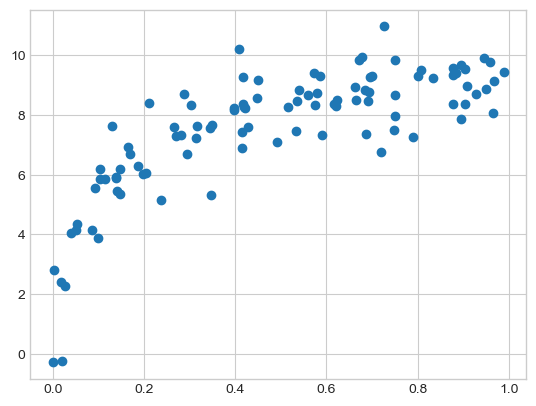

In [60]:
X,y = gen_data(100, error=1)
plt.scatter(X.ravel(),y)

## Underfitting model
So let's say we want to perform a regression on the generated sample data above, we could use the built-in linear regression function to compute the fit:

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X,y)

LinearRegression()

Make a test set:

In [62]:
X_test = np.linspace(-0.1, 1.1, 500)[:,None]
y_test = model.predict(X_test)

Plot the results:

Text(0.5, 1.0, 'Mean squared error: 1.84')

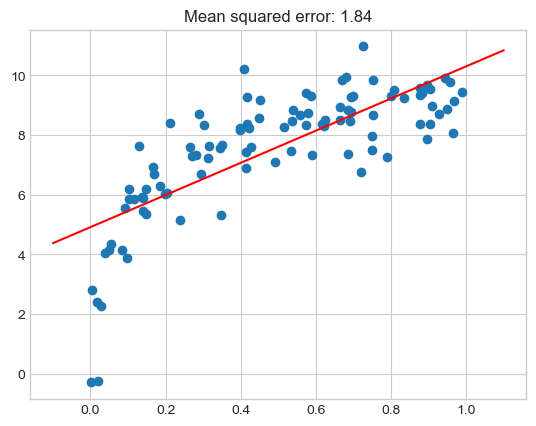

In [63]:
plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test, c='r')
plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))

In the above, we have fit a straight line to the data (in red). Clearly this 
is model is not a good choice. This model is called *biased*, or that it *underfits* the data. In other words, the underfitting model is not complex enough for this dataset.

### Solution?
We could improve this by making the model a bit more complicated, thus increasing model's *capacity* to learn.

## Adding degrees of freedom
One of the many ways of doing this is by adding degrees of freedom, and computing a polynomial regressor over the inputs. Degree of freedom represents the number of points of control of a system or in machine learning it is bascially the number of parameters of a model. Higher degrees of freedom translates to a more complex model.

Again fortunately sklearn has an utility function called `PolynomialFeatures` preprocessor, that we can pipeline into our linear regression routine:




In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polyreg(degree=2, **kwargs):
  return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

poly_model = polyreg(2)
poly_model.fit(X,y)
y_test = poly_model.predict(X_test)

And plot the results:

Text(0.5, 1.0, 'Mean squared error: 1.13')

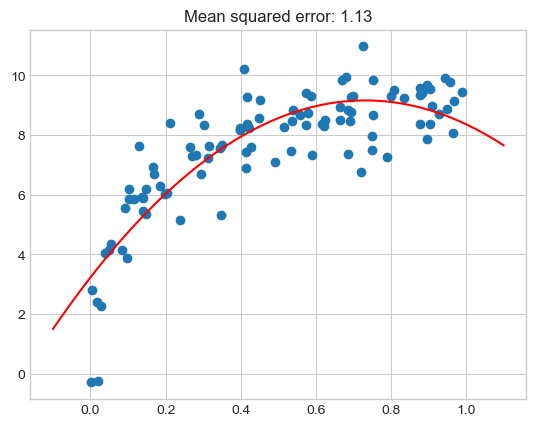

In [74]:
plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test, c='r')
plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(poly_model.predict(X), y)))

Looks better? Notice that this reduces the mean squared error and makes a much better fit, although the fit could be improved by using higher-degree polynomial.


## Overfitting model
What happens if we use an even higher-degree polynomial - say a polynomial with a degree of 30?

In [66]:
over_model = polyreg(30)
over_model.fit(X,y)
y_test = over_model.predict(X_test)

As usual, plot the results:

(-4.0, 14.0)

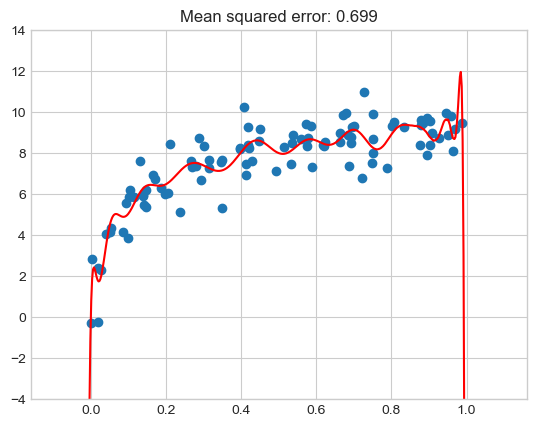

In [67]:
plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test, c='r')
plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(over_model.predict(X), y)))
plt.ylim(-4, 14)

When we increase the degree to this extent, it is clear that the resulting fit is no longer reflecting the true underlying distribution. Despite of lowe mean squared error, the model is more sensitive to the noise in the training data (notice the spikes).

The above model is known as a *high-variance model* which means that it *overfits* the data. An overfitting model has learned the training data a bit *too well*, and will generalise poorly to new data points.

## Bias-variance tradeoff
To achieve a balance between the bias error and the variance error, we need a degree such that the model neither learns from the noise (overfit on data) nor makes sweeping assumptions on the data (underfit on data). 

To illustrate this, we can select different values for the polynomial degree and number of data points for our model:

In [77]:
from ipywidgets import interact

def polyfit(degree=1, n=50):
  X,y=gen_data(n, error=1)
  X_test = np.linspace(-0.1, 1.1, 500)[:,None]

  # fit a polynomial regressor  
  model = polyreg(degree=degree)
  model.fit(X,y)
  y_test = model.predict(X_test)

  # plot the results:
  plt.scatter(X.ravel(), y)
  plt.plot(X_test.ravel(), y_test, c='r')
  plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))

interact(polyfit, degree=[1, 2, 3, 4, 5, 10, 15, 20, 30], n=[2, 10, 50, 100, 500, 1000]) 

interactive(children=(Dropdown(description='degree', options=(1, 2, 3, 4, 5, 10, 15, 20, 30), value=1), Dropdo…

<function __main__.polyfit(degree=1, n=50)>

As you can see, it is a tradeoff, but we will be able to identify values that are close to being optimal.

# Validation curves

Evidently, computing the mean-squared error on the training data is not sufficient. We can use *cross-validation* to get a better handle on how the model fit is working.

More importantly, we will use *validation curves* to identify how complex our model should be using sklearn's `validation_curve`. To start off, let's generate a sample dataset using our `gen_data` function:

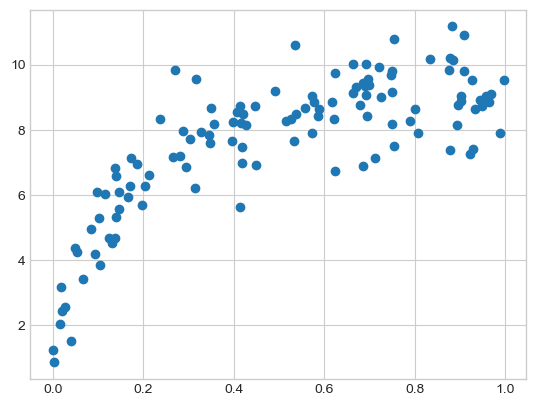

In [78]:
X,y=gen_data(120, error=1.0)
plt.scatter(X,y)

## Detecting underfitting and overfitting
Using `validation_curve` allows us to identify how well the model fits the data. We will add a function called `calc_rmse` to compute root-mean-square error and then plot the error value, based on the number of degrees of freedom in the model:

In [79]:
from sklearn.model_selection import validation_curve

def calc_rmse(model, X, y):
  y_pred = model.predict(X)
  return np.sqrt(np.mean((y-y_pred) ** 2))

def plot_with_error(x, data, **kwargs):
  mu, std = data.mean(1), data.std(1)
  lines = plt.plot(x, mu, '-', **kwargs)
  plt.fill_between(
      x, mu - std, mu + std, edgecolor="none", facecolor=lines[0].get_color(), alpha=.2
  )

Try a range of degrees up to 17:

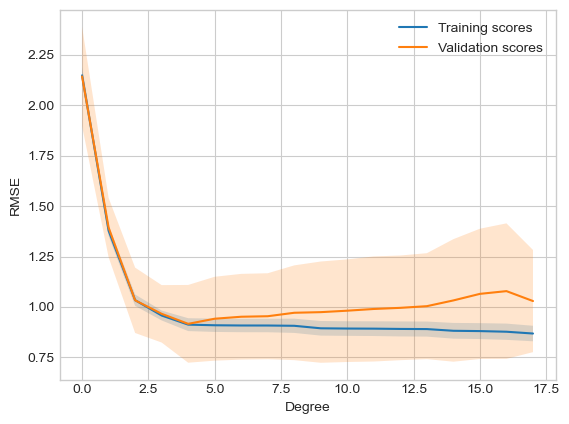

In [80]:
degree = np.arange(0,18)
val_train, val_test = validation_curve(
    polyreg(), X, y, param_name = "polynomialfeatures__degree", param_range=degree, cv=7, scoring=calc_rmse
)

plot_with_error(degree, val_train, label="Training scores")
plot_with_error(degree, val_test, label="Validation scores")
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.legend()

Let's talk about the plot above:

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is underfitting the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a high-bias model. 
2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is overfitting the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a high-variance model. 
3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is at around 5 terms.

## Best-fit model
Validation curve makes it much easier to select model's hyperparameters. Judging by the plot we got previously, the validation score dips at 4 degrees, which must be the optimal degree of a polynomial model. 

Here's our best-fit model according to the cross-validation:

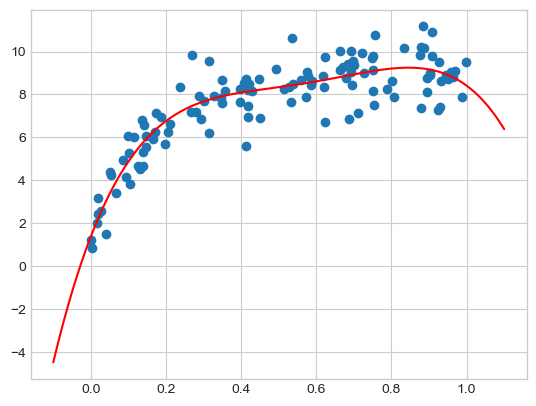

In [81]:
model = polyreg(4).fit(X, y) 
plt.scatter(X, y) 
plt.plot(X_test, model.predict(X_test), c='r');

# Learning curves
## Linear regression
As we can see previously, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used. 

Here we'll illustrate the use of learning curves, which display this property. The idea is to plot the RMSE (root-mean-square error) for the training and test set as a function of the number of training points. Let's see what the learning curves look like for a linear model (i.e.  $d=1$):

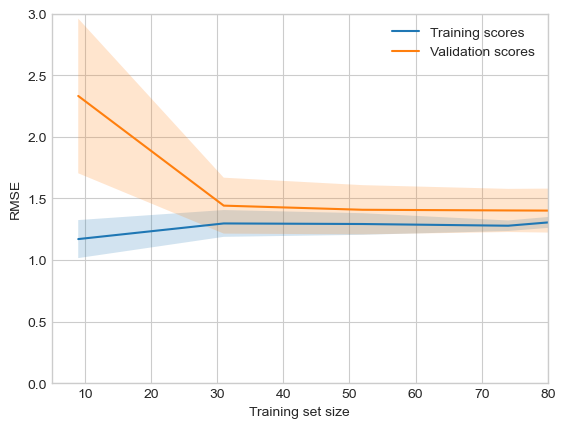

In [86]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 120)
    N_train, val_train, val_test = learning_curve(
        polyreg(degree), X, y, groups=train_sizes, 
        cv=5, scoring=calc_rmse
    )
    plot_with_error(N_train, val_train, label='Training scores')
    plot_with_error(N_train, val_test, label='Validation scores')
    plt.xlabel('Training set size'); plt.ylabel('RMSE')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

# deg of freedom parameter
plot_learning_curve(1)

The plot shows a typical learning curve: 

1. For very few training points, there is a large separation between the training and test error, which indicates overfitting. 
2. Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential underfitting. 


As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?).

## Polynomial regression
It is easy to see from the validation curves of the linear model, that if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will never get you there. For  $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

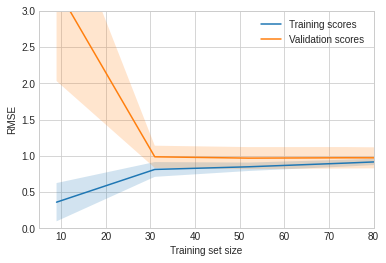

In [41]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0! What if we get even more complex?

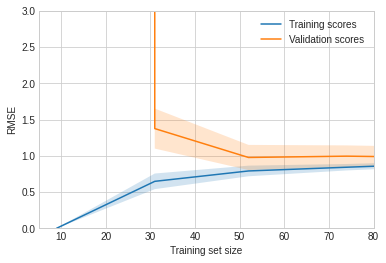

In [42]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for large amounts of training data. So we see the following:

* You can cause the lines to converge by adding more points or by simplifying the model. 
* You can bring the convergence error down only by increasing the complexity of the model. 

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data. 

To make this more concrete, imagine some telescope data in which the results are not robust enough. You must think about whether to spend your valuable telescope time *observing more objects* to get a larger training set, or more attributes of each object in order to improve the model. The answer to this question has real consequences, and can be addressed using these metrics.

# Summary

We've gone over several useful tools for model validation: 

1. The training score shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness. 
2. The validation score shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used. 
3. *Validation curves* are a plot of validation score and training score as a function of model complexity: 
> * when the two curves are close, it indicates underfitting,
> * when the two curves are separated, it indicates overfitting, 
> * the "sweet spot" is in the middle. 
4. Learning curves are a plot of the validation score and training score as a function of number of training samples: 
> * when the curves are close, it indicates underfitting, and adding more data will not generally improve the estimator, 
> * when the curves are far apart, it indicates overfitting, and adding more data may increase the effectiveness of the model. 

These tools are powerful means of evaluating your model on your data.